In [1]:
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_datareader import data
from scipy.stats import pearsonr
from pypfopt import expected_returns, risk_models, plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#### Data Import

In [2]:
# import price data (adj close)

#spdrs_list = ['XLB','XLC','XLE','XLF','XLI','XLK','XLP','XLRE','XLU','XLV','XLY'] 
spdrs_list = ['XLB','VOX','XLE','XLF','XLI','XLK','XLP','IYR','XLU','XLV','XLY']     # XLC ==> VOX, XLRE ==> IYR
   

spdrs_stat_date = datetime.datetime(2014, 1, 1)
spdrs_end_date = datetime.datetime(2019, 12, 31)

spdrs_price_df = pd.DataFrame()

for spdrs_name in spdrs_list:        
    df = data.get_data_yahoo(spdrs_name, spdrs_stat_date, spdrs_end_date)
    spdrs_price_df[spdrs_name] = df['Adj Close']
    
# DataFrame of ETFs' price    
spdrs_price_df

,XLB,VOX,XLE,XLF,XLI,XLK,XLP,IYR,XLU,XLV,XLY
Date,,,,,,,,,,,
2013-12-31,39.781387,72.149460,66.326424,15.372337,45.100849,31.869316,35.226295,48.451271,29.487286,49.048355,60.550556
2014-01-02,39.462929,71.528519,65.382210,15.287949,44.470848,31.557217,34.791908,48.374454,29.036858,48.774105,60.269672
2014-01-03,39.368259,71.321556,65.142441,15.393431,44.591675,31.405630,34.726334,48.658653,28.943678,48.889114,60.106598
2014-01-06,39.153088,71.571640,65.232361,15.407503,44.332764,31.352112,34.595215,48.858345,28.990271,48.685623,59.735107
2014-01-07,39.084229,72.080452,65.726936,15.414529,44.608921,31.637468,34.783710,49.027328,29.246548,49.198750,60.097538
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,59.291908,92.998398,55.247555,29.654032,79.649132,89.694038,60.466576,88.187439,60.928539,99.836365,122.781921
2019-12-26,59.553837,93.719543,55.229717,29.818348,79.834190,90.362526,60.524250,88.658531,61.033138,99.768501,124.280457
2019-12-27,59.330715,93.541725,54.997887,29.741024,79.765999,90.352684,60.793369,88.898865,61.213787,99.797585,124.270607


#### Calculate Return

In [3]:
# Create empty dataframe for keep returns
spdrs_daily_ret_df = pd.DataFrame()

for i in spdrs_price_df.columns:
    # Compute daily return
    # spdrs_daily_ret_df[i] = np.log(spdrs_price_df[i].astype('float64')/spdrs_price_df[i].astype('float64').shift(1))
    spdrs_daily_ret_df[i] = spdrs_price_df[i].pct_change()

# Deal with NaN
spdrs_daily_ret_df= spdrs_daily_ret_df.dropna()

# DataFrame of ETFs' return
spdrs_daily_ret_df

,XLB,VOX,XLE,XLF,XLI,XLK,XLP,IYR,XLU,XLV,XLY
Date,,,,,,,,,,,
2014-01-02,-0.008005,-0.008606,-0.014236,-0.005490,-0.013969,-0.009793,-0.012331,-0.001585,-0.015275,-0.005591,-0.004639
2014-01-03,-0.002399,-0.002893,-0.003667,0.006900,0.002717,-0.004804,-0.001885,0.005875,-0.003209,0.002358,-0.002706
2014-01-06,-0.005466,0.003506,0.001380,0.000914,-0.005806,-0.001704,-0.003776,0.004104,0.001610,-0.004162,-0.006181
2014-01-07,-0.001759,0.007109,0.007582,0.000456,0.006229,0.009102,0.005449,0.003459,0.008840,0.010540,0.006067
2014-01-08,0.005946,-0.001196,-0.006955,0.003194,-0.001741,0.000000,-0.007540,-0.001567,-0.005311,0.008812,-0.002714
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.001147,-0.000955,-0.000484,0.002287,-0.004019,0.000329,0.001273,0.002733,0.001406,-0.001261,0.002253
2019-12-26,0.004418,0.007754,-0.000323,0.005541,0.002323,0.007453,0.000954,0.005342,0.001717,-0.000680,0.012205
2019-12-27,-0.003747,-0.001897,-0.004198,-0.002593,-0.000854,-0.000109,0.004446,0.002711,0.002960,0.000292,-0.000079


#### Using 2019 data. Robust method for calculation of EFs for all 165 combinations

In [4]:
# select only price data of 2019
spdrs_daily_ret_2019 = spdrs_daily_ret_df.loc['2019']
spdrs_daily_ret_2019

,XLB,VOX,XLE,XLF,XLI,XLK,XLP,IYR,XLU,XLV,XLY
Date,,,,,,,,,,,
2019-01-02,0.005146,0.013096,0.019704,0.008396,0.005123,0.000645,-0.005908,-0.021617,-0.017196,-0.015143,0.007575
2019-01-03,-0.028358,-0.013460,-0.009918,-0.022481,-0.030429,-0.050468,-0.005745,0.006410,-0.000192,-0.020305,-0.021652
2019-01-04,0.039319,0.041470,0.034024,0.033220,0.037916,0.044320,0.021319,0.010706,0.014808,0.029831,0.033094
2019-01-07,0.003510,0.009338,0.014865,0.001237,0.008135,0.008943,-0.001366,0.010056,-0.006822,0.003839,0.022612
2019-01-08,0.010494,0.016962,0.007735,0.000823,0.013703,0.008380,0.009181,0.018187,0.012402,0.007765,0.011056
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.001147,-0.000955,-0.000484,0.002287,-0.004019,0.000329,0.001273,0.002733,0.001406,-0.001261,0.002253
2019-12-26,0.004418,0.007754,-0.000323,0.005541,0.002323,0.007453,0.000954,0.005342,0.001717,-0.000680,0.012205
2019-12-27,-0.003747,-0.001897,-0.004198,-0.002593,-0.000854,-0.000109,0.004446,0.002711,0.002960,0.000292,-0.000079


### 2.1 Recall assignment 2, 3 portfolios all combinations (5).

In [5]:
# Column's name of Empty dictinary
columns = ['Portfolio', 'weight_assset_1', 'weight_assset_2', 'weight_assset_3', 'return', 'std_dev', 'sharpe_ratio']
# Empty dictionary for keep portfolio information (weight, return, stdev, sharpe)
trained_portfolios = pd.DataFrame(columns=columns)

# Find each portfolio from 165 portfolios (11 chose 3)
for port in itertools.combinations(spdrs_daily_ret_2019.columns, 3):
    port_info = []
    # select only 3 asssets that is in each portfolio
    df1 = spdrs_price_df[list(port)]
    # Return for each assets
    mu1 = expected_returns.mean_historical_return(df1)
    # Covariance matrix
    S1 = risk_models.sample_cov(df1)
    ef1 = EfficientFrontier(mu1, S1, weight_bounds=(None,None))    # generate optimal portfolios
    ef1.add_constraint(lambda w1: w1[0]+w1[1]+w1[2] == 1)          # adds a constraint to the optimization problem
    weights1 = ef1.max_sharpe()                                    # optimizes for maximal Sharpe ratio
    cleaned_weights1 = ef1.clean_weights()                         # rounds the weights and clips near-zeros
    # get portfolio performance (return, standard deviation, sharpe ration)
    port_perf = ef1.portfolio_performance(verbose=False)
    # keep all value (elements portfolio, 3 weights, 3 portfolio performances) in empty list
    port_info.extend([port, 
                      cleaned_weights1[port[0]],cleaned_weights1[port[1]],cleaned_weights1[port[2]],
                      port_perf[0], port_perf[1], port_perf[2]])
    
    # transform list to row of dataframe
    df_length = len(trained_portfolios)
    trained_portfolios.loc[df_length] = port_info
    
# setting for show all rows of DataFrame
pd.set_option('display.max_rows', None)

trained_portfolios

,Portfolio,weight_assset_1,weight_assset_2,weight_assset_3,return,std_dev,sharpe_ratio
0,"(XLB, VOX, XLE)",1.00000,1.00000,-1.00000,0.142993,0.205146,0.599537
1,"(XLB, VOX, XLF)",0.17104,-0.17104,1.00000,0.121087,0.170271,0.593686
2,"(XLB, VOX, XLI)",0.12640,-0.12640,1.00000,0.102262,0.155520,0.528951
3,"(XLB, VOX, XLK)",0.15999,-0.15999,1.00000,0.193726,0.170330,1.019937
4,"(XLB, VOX, XLP)",0.21781,-0.21781,1.00000,0.100412,0.120848,0.665400
5,"(XLB, VOX, IYR)",0.30196,-0.30196,1.00000,0.115923,0.139859,0.685857
6,"(XLB, VOX, XLU)",0.29871,-0.29871,1.00000,0.138362,0.143671,0.823840
7,"(XLB, VOX, XLV)",0.18354,-0.18354,1.00000,0.130027,0.153852,0.715145
8,"(XLB, VOX, XLY)",0.20574,-0.20574,1.00000,0.132068,0.151032,0.742018
9,"(XLB, XLE, XLF)",1.00000,-1.00000,1.00000,0.216602,0.217362,0.904488


### 2.2 Determine the EF under no constraints as in 4.2 again

In [6]:
# in case of no constraint
# create empty list for keep portfolio performance of all portfolio
list_perf_no_constraint =[]
for i in range(trained_portfolios.iloc[:,0].shape[0]):
    
    # DataFrame of selected ETF for portfolio
    df1 = spdrs_price_df[list(trained_portfolios.iloc[:,0][i])]
    
    # Calculate the expected returns and the annualized sample covariance matrix of asset returns
    mu1 = expected_returns.mean_historical_return(df1)
    S1 = risk_models.sample_cov(df1)
    
    # Optimize for maximum sharpe ratio
    ef1 = EfficientFrontier(mu1, S1, weight_bounds=(None,None))   # Determine the EF under no constraints about short/long
    ef1.add_constraint(lambda w1: w1[0]+w1[1]+w1[2] == 1)         # Add a constraint to the optimization problem
    weights1 = ef1.max_sharpe()                                   # optimizes for maximal Sharpe ratio
    cleaned_weights1 = ef1.clean_weights()                        # rounds the weights and clips near-zeros
    print(cleaned_weights1)
    
    # create list for keep data of portfolio performance
    perf = [i for i in ef1.portfolio_performance(verbose=True)]
    # keep portfolio performance of all portfolio
    list_perf_no_constraint.append(perf)
    
# list to array   
all_perf_no_constraint = np.array(list_perf_no_constraint)
# array to pandas ==> easy for calculate statistics
df_perf_no_constraint = pd.DataFrame(all_perf_no_constraint, 
                                     columns = ['Annual_Return', 'Annual_Volatility', 'Sharpe_Ratio'])

OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 14.3%
Annual volatility: 20.5%
Sharpe Ratio: 0.60
OrderedDict([('XLB', 0.17104), ('VOX', -0.17104), ('XLF', 1.0)])
Expected annual return: 12.1%
Annual volatility: 17.0%
Sharpe Ratio: 0.59
OrderedDict([('XLB', 0.1264), ('VOX', -0.1264), ('XLI', 1.0)])
Expected annual return: 10.2%
Annual volatility: 15.6%
Sharpe Ratio: 0.53
OrderedDict([('XLB', 0.15999), ('VOX', -0.15999), ('XLK', 1.0)])
Expected annual return: 19.4%
Annual volatility: 17.0%
Sharpe Ratio: 1.02
OrderedDict([('XLB', 0.21781), ('VOX', -0.21781), ('XLP', 1.0)])
Expected annual return: 10.0%
Annual volatility: 12.1%
Sharpe Ratio: 0.67
OrderedDict([('XLB', 0.30196), ('VOX', -0.30196), ('IYR', 1.0)])
Expected annual return: 11.6%
Annual volatility: 14.0%
Sharpe Ratio: 0.69
OrderedDict([('XLB', 0.29871), ('VOX', -0.29871), ('XLU', 1.0)])
Expected annual return: 13.8%
Annual volatility: 14.4%
Sharpe Ratio: 0.82
OrderedDict([('XLB', 0.18354), ('VOX'

OrderedDict([('VOX', -0.45867), ('XLP', 0.80009), ('IYR', 0.65858)])
Expected annual return: 12.7%
Annual volatility: 13.6%
Sharpe Ratio: 0.79
OrderedDict([('VOX', -0.29249), ('XLP', 0.60477), ('XLU', 0.68772)])
Expected annual return: 13.4%
Annual volatility: 13.3%
Sharpe Ratio: 0.86
OrderedDict([('VOX', -0.63915), ('XLP', 0.789), ('XLV', 0.85015)])
Expected annual return: 15.4%
Annual volatility: 15.4%
Sharpe Ratio: 0.87
OrderedDict([('VOX', -0.78811), ('XLP', 0.78811), ('XLY', 1.0)])
Expected annual return: 16.7%
Annual volatility: 15.5%
Sharpe Ratio: 0.95
OrderedDict([('VOX', -0.2673), ('IYR', 0.50219), ('XLU', 0.76511)])
Expected annual return: 14.2%
Annual volatility: 14.6%
Sharpe Ratio: 0.84
OrderedDict([('VOX', -0.68492), ('IYR', 0.76077), ('XLV', 0.92415)])
Expected annual return: 16.8%
Annual volatility: 16.4%
Sharpe Ratio: 0.90
OrderedDict([('VOX', -0.76604), ('IYR', 0.76604), ('XLY', 1.0)])
Expected annual return: 17.6%
Annual volatility: 16.0%
Sharpe Ratio: 0.98
OrderedDic

OrderedDict([('XLI', -0.43483), ('XLK', 1.0), ('XLY', 0.43483)])
Expected annual return: 20.1%
Annual volatility: 17.5%
Sharpe Ratio: 1.04
OrderedDict([('XLI', 0.15621), ('XLP', 0.40621), ('IYR', 0.43757)])
Expected annual return: 10.1%
Annual volatility: 11.2%
Sharpe Ratio: 0.73
OrderedDict([('XLI', 0.27089), ('XLP', 0.09664), ('XLU', 0.63247)])
Expected annual return: 11.8%
Annual volatility: 11.5%
Sharpe Ratio: 0.86
OrderedDict([('XLI', -0.07313), ('XLP', 0.5), ('XLV', 0.57313)])
Expected annual return: 11.2%
Annual volatility: 12.1%
Sharpe Ratio: 0.76
OrderedDict([('XLI', -0.30332), ('XLP', 0.49235), ('XLY', 0.81097)])
Expected annual return: 11.9%
Annual volatility: 12.7%
Sharpe Ratio: 0.78
OrderedDict([('XLI', 0.27791), ('IYR', 0.1004), ('XLU', 0.6217)])
Expected annual return: 11.9%
Annual volatility: 11.6%
Sharpe Ratio: 0.86
OrderedDict([('XLI', -0.05046), ('IYR', 0.48199), ('XLV', 0.56847)])
Expected annual return: 11.8%
Annual volatility: 12.5%
Sharpe Ratio: 0.78
OrderedDict(

In [7]:
df_perf_no_constraint

,Annual_Return,Annual_Volatility,Sharpe_Ratio
0,0.142993,0.205146,0.599537
1,0.121087,0.170271,0.593686
2,0.102262,0.155520,0.528951
3,0.193726,0.170330,1.019937
4,0.100412,0.120848,0.665400
5,0.115923,0.139859,0.685857
6,0.138362,0.143671,0.823840
7,0.130027,0.153852,0.715145
8,0.132068,0.151032,0.742018
9,0.216601,0.217362,0.904487


In [8]:
# Calculate average of annual return, annual volatility, sharpe ratio
average_perf_no_constraint = df_perf_no_constraint.mean()
average_perf_no_constraint

Annual_Return        0.173182
Annual_Volatility    0.158158
Sharpe_Ratio         0.953812
dtype: float64

OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 14.3%
Annual volatility: 20.5%
Sharpe Ratio: 0.60


(0.1429925102721131, 0.20514576555229824, 0.5995371629582008)

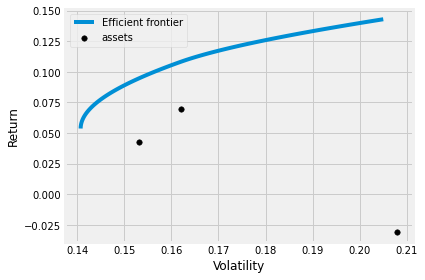

In [9]:
# Select portfolio of XLB, VOX, XLE for displaying EF

# DataFrame of selected ETF for portfolio
df1 = spdrs_price_df[list(trained_portfolios.iloc[:,0][0])] # Select XLB,VOX, XLE
# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu1 = expected_returns.mean_historical_return(df1)
S1 = risk_models.sample_cov(df1)

# Optimize for maximum sharpe ratio
ef1 = EfficientFrontier(mu1, S1, weight_bounds=(None,None))   # Determine the EF under no constraints about short/long
ef1.add_constraint(lambda w1: w1[0]+w1[1]+w1[2] == 1)         # adds a constraint to the optimization problem
plotting.plot_efficient_frontier(ef1)
weights1 = ef1.max_sharpe()                                   # optimizes for maximal Sharpe ratio
cleaned_weights1 = ef1.clean_weights()                        # rounds the weights and clips near-zeros
print(cleaned_weights1)

ef1.portfolio_performance(verbose=True)

### 2.3 Determine the EF under long only constraints

In [10]:
# in case of long only
# create empty list for keep portfolio performance of all portfolio
list_perf_long = []   
for i in range(trained_portfolios.iloc[:,0].shape[0]):
    
    # DataFrame of selected ETF for portfolio
    df2 = spdrs_price_df[list(trained_portfolios.iloc[:,0][i])]
    
    # Calculate the expected returns and the annualized sample covariance matrix of asset returns
    mu2 = expected_returns.mean_historical_return(df2)
    S2 = risk_models.sample_cov(df2)
    
    # Optimize for maximum sharpe ratio
    ef2 = EfficientFrontier(mu2, S2, weight_bounds=(0,1))    # Determine the EF under long only
    ef2.add_constraint(lambda w1: w1[0]+w1[1]+w1[2] == 1)    # Add a constraint to the optimization problem
    weights2 = ef2.max_sharpe()                              # optimizes for maximal Sharpe ratio
    cleaned_weights2 = ef2.clean_weights()                   # rounds the weights and clips near-zeros
    print(cleaned_weights2)
    
    # create list for keep data of portfolio performance
    perf = [i for i in ef2.portfolio_performance(verbose=True)]
    # keep portfolio performance of all portfolio
    list_perf_long.append(perf)
    
# list to array       
all_perf_long = np.array(list_perf_long)
# array to pandas ==> easy for calculate statistics
df_perf_long = pd.DataFrame(all_perf_long, 
                            columns = ['Annual_Return', 'Annual_Volatility', 'Sharpe_Ratio'])

OrderedDict([('XLB', 1.0), ('VOX', 0.0), ('XLE', 0.0)])
Expected annual return: 7.0%
Annual volatility: 16.2%
Sharpe Ratio: 0.31
OrderedDict([('XLB', 0.0), ('VOX', 0.0), ('XLF', 1.0)])
Expected annual return: 11.6%
Annual volatility: 16.4%
Sharpe Ratio: 0.59
OrderedDict([('XLB', 0.0), ('VOX', 0.0), ('XLI', 1.0)])
Expected annual return: 9.9%
Annual volatility: 15.0%
Sharpe Ratio: 0.53
OrderedDict([('XLB', 0.0), ('VOX', 0.0), ('XLK', 1.0)])
Expected annual return: 18.9%
Annual volatility: 16.8%
Sharpe Ratio: 1.01
OrderedDict([('XLB', 0.0), ('VOX', 0.0), ('XLP', 1.0)])
Expected annual return: 9.5%
Annual volatility: 11.6%
Sharpe Ratio: 0.64
OrderedDict([('XLB', 0.0145), ('VOX', 0.0), ('IYR', 0.9855)])
Expected annual return: 10.7%
Annual volatility: 13.4%
Sharpe Ratio: 0.65
OrderedDict([('XLB', 0.12881), ('VOX', 0.0), ('XLU', 0.87119)])
Expected annual return: 12.3%
Annual volatility: 12.8%
Sharpe Ratio: 0.80
OrderedDict([('XLB', 0.0), ('VOX', 0.0), ('XLV', 1.0)])
Expected annual return:

OrderedDict([('VOX', 0.0), ('XLI', 0.0), ('XLY', 1.0)])
Expected annual return: 12.7%
Annual volatility: 14.6%
Sharpe Ratio: 0.73
OrderedDict([('VOX', 0.0), ('XLK', 0.89117), ('XLP', 0.10883)])
Expected annual return: 17.9%
Annual volatility: 15.7%
Sharpe Ratio: 1.01
OrderedDict([('VOX', 0.0), ('XLK', 0.78469), ('IYR', 0.21531)])
Expected annual return: 17.2%
Annual volatility: 14.8%
Sharpe Ratio: 1.03
OrderedDict([('VOX', 0.0), ('XLK', 0.56131), ('XLU', 0.43869)])
Expected annual return: 16.4%
Annual volatility: 12.5%
Sharpe Ratio: 1.15
OrderedDict([('VOX', 0.0), ('XLK', 1.0), ('XLV', 0.0)])
Expected annual return: 18.9%
Annual volatility: 16.8%
Sharpe Ratio: 1.01
OrderedDict([('VOX', 0.0), ('XLK', 1.0), ('XLY', 0.0)])
Expected annual return: 18.9%
Annual volatility: 16.8%
Sharpe Ratio: 1.01
OrderedDict([('VOX', 0.0), ('XLP', 0.51961), ('IYR', 0.48039)])
Expected annual return: 10.1%
Annual volatility: 11.3%
Sharpe Ratio: 0.72
OrderedDict([('VOX', 0.0), ('XLP', 0.35979), ('XLU', 0.640

OrderedDict([('XLF', 0.09894), ('XLU', 0.5383), ('XLY', 0.36276)])
Expected annual return: 12.8%
Annual volatility: 11.2%
Sharpe Ratio: 0.96
OrderedDict([('XLF', 0.0), ('XLV', 0.44618), ('XLY', 0.55382)])
Expected annual return: 12.6%
Annual volatility: 13.7%
Sharpe Ratio: 0.77
OrderedDict([('XLI', 0.0), ('XLK', 0.89117), ('XLP', 0.10883)])
Expected annual return: 17.9%
Annual volatility: 15.7%
Sharpe Ratio: 1.01
OrderedDict([('XLI', 0.0), ('XLK', 0.78469), ('IYR', 0.21531)])
Expected annual return: 17.2%
Annual volatility: 14.8%
Sharpe Ratio: 1.03
OrderedDict([('XLI', 0.0), ('XLK', 0.56131), ('XLU', 0.43869)])
Expected annual return: 16.4%
Annual volatility: 12.5%
Sharpe Ratio: 1.15
OrderedDict([('XLI', 0.0), ('XLK', 1.0), ('XLV', 0.0)])
Expected annual return: 18.9%
Annual volatility: 16.8%
Sharpe Ratio: 1.01
OrderedDict([('XLI', 0.0), ('XLK', 1.0), ('XLY', 0.0)])
Expected annual return: 18.9%
Annual volatility: 16.8%
Sharpe Ratio: 1.01
OrderedDict([('XLI', 0.15621), ('XLP', 0.40621)

In [11]:
df_perf_long

,Annual_Return,Annual_Volatility,Sharpe_Ratio
0,0.069742,0.162142,0.306781
1,0.116493,0.164120,0.587943
2,0.098867,0.150020,0.525713
3,0.189429,0.167580,1.011030
4,0.094562,0.115833,0.643705
5,0.107261,0.133510,0.653593
6,0.122533,0.128485,0.798021
7,0.125097,0.149049,0.705120
8,0.126542,0.146281,0.728342
9,0.116492,0.164120,0.587936


In [12]:
# Calculate average of annual return, annual volatility, sharpe ratio
average_long = df_perf_long.mean()
average_long

Annual_Return        0.133766
Annual_Volatility    0.134716
Sharpe_Ratio         0.841062
dtype: float64

OrderedDict([('XLB', 1.0), ('VOX', 0.0), ('XLE', 0.0)])
Expected annual return: 7.0%
Annual volatility: 16.2%
Sharpe Ratio: 0.31


(0.06974201293274092, 0.16214188256379525, 0.30678077832955813)

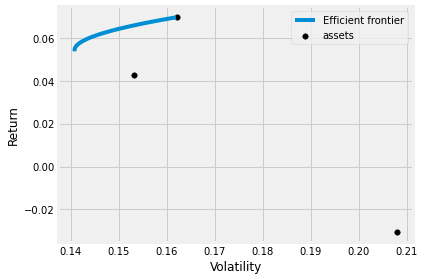

In [13]:
# Select portfolio of XLB, VOX, XLE for displaying EF

# DataFrame of selected ETF for portfolio
df2 = spdrs_price_df[list(trained_portfolios.iloc[:,0][0])] # Select XLB,VOX, XLE
# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu2 = expected_returns.mean_historical_return(df2)
S2 = risk_models.sample_cov(df2)

# Optimize for maximum sharpe ratio
ef2 = EfficientFrontier(mu2, S2, weight_bounds=(0,1))   # Determine the EF under long only
ef2.add_constraint(lambda w1: w1[0]+w1[1]+w1[2] == 1)   # adds a constraint to the optimization problem
plotting.plot_efficient_frontier(ef2)
weights2 = ef2.max_sharpe()                             # optimizes for maximal Sharpe ratio
cleaned_weights2 = ef2.clean_weights()                  # rounds the weights and clips near-zeros
print(cleaned_weights2)

ef2.portfolio_performance(verbose=True)

### 2.4 Determine the EF under box constraints of minimum weight of 10%, and maximum weight of 40%.  (The later limit concentration risk)

In [14]:
list_perf_weight_constraint = []
for i in range(trained_portfolios.iloc[:,0].shape[0]):
    
    # DataFrame of selected ETF for portfolio
    df3 = spdrs_price_df[list(trained_portfolios.iloc[:,0][i])]
    
    # Calculate the expected returns and the annualized sample covariance matrix of asset returns
    mu3 = expected_returns.mean_historical_return(df3)
    S3 = risk_models.sample_cov(df3)
    
    # Optimize for maximum sharpe ratio
    ef3 = EfficientFrontier(mu3, S3, weight_bounds=(0,1))    # Determine the EF under long only
    ef3.add_constraint(lambda w1: w1 >= 0.1)                 # Add a constraint minimum weight of 10%
    ef3.add_constraint(lambda w1: w1 <= 0.4)                 # Add a constraint maximum weight of 40%
    weights3 = ef3.max_sharpe()                              # optimizes for maximal Sharpe ratio
    cleaned_weights3 = ef1.clean_weights()                   # rounds the weights and clips near-zeros
    print(cleaned_weights3)

    # create list for keep data of portfolio performance
    perf_weight_constraint = [i for i in ef3.portfolio_performance(verbose=True)]
    # keep portfolio performance of all portfolio
    list_perf_weight_constraint.append(perf_weight_constraint)

# list to array
all_perf_weight_constraint = np.array(list_perf_weight_constraint)
# array to pandas ==> easy for calculate statistics
df_perf_weight_constraint = pd.DataFrame(all_perf_weight_constraint, 
                                         columns = ['Annual_Return', 'Annual_Volatility', 'Sharpe_Ratio'])

OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 3.9%
Annual volatility: 14.5%
Sharpe Ratio: 0.13
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 8.3%
Annual volatility: 14.4%
Sharpe Ratio: 0.44
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 7.6%
Annual volatility: 14.2%
Sharpe Ratio: 0.40
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 11.2%
Annual volatility: 14.5%
Sharpe Ratio: 0.64
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 7.4%
Annual volatility: 12.1%
Sharpe Ratio: 0.45
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 8.0%
Annual volatility: 12.4%
Sharpe Ratio: 0.48
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 8.9%
Annual volatility: 11.6%
Sharpe Ratio: 0.59
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 8.7%
Ann

OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 10.0%
Annual volatility: 11.3%
Sharpe Ratio: 0.71
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 9.8%
Annual volatility: 13.3%
Sharpe Ratio: 0.59
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 9.9%
Annual volatility: 13.6%
Sharpe Ratio: 0.58
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 12.2%
Annual volatility: 12.5%
Sharpe Ratio: 0.82
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 12.7%
Annual volatility: 12.8%
Sharpe Ratio: 0.84
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 13.6%
Annual volatility: 12.0%
Sharpe Ratio: 0.97
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 13.4%
Annual volatility: 14.0%
Sharpe Ratio: 0.81
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 13.5

OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 10.1%
Annual volatility: 11.1%
Sharpe Ratio: 0.72
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 11.0%
Annual volatility: 10.8%
Sharpe Ratio: 0.83
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 10.8%
Annual volatility: 11.9%
Sharpe Ratio: 0.74
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 10.8%
Annual volatility: 12.0%
Sharpe Ratio: 0.73
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 11.4%
Annual volatility: 11.3%
Sharpe Ratio: 0.84
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 11.3%
Annual volatility: 12.1%
Sharpe Ratio: 0.77
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 11.4%
Annual volatility: 12.3%
Sharpe Ratio: 0.76
OrderedDict([('XLB', 1.0), ('VOX', 1.0), ('XLE', -1.0)])
Expected annual return: 12

In [15]:
df_perf_weight_constraint

,Annual_Return,Annual_Volatility,Sharpe_Ratio
0,0.038977,0.144692,0.131157
1,0.083071,0.143521,0.439454
2,0.076021,0.141664,0.395447
3,0.112245,0.145202,0.635290
4,0.074299,0.120678,0.449945
5,0.079599,0.123569,0.482313
6,0.088609,0.115834,0.592306
7,0.086513,0.134775,0.493506
8,0.087091,0.137983,0.486223
9,0.068421,0.153699,0.315037


In [17]:
# Calculate average of annual return, annual volatility, sharpe ratio
average_weight_constraint = df_perf_weight_constraint.mean()
average_weight_constraint

Annual_Return        0.106981
Annual_Volatility    0.127704
Sharpe_Ratio         0.688679
dtype: float64

OrderedDict([('XLB', 0.4), ('VOX', 0.4), ('XLE', 0.2)])
Expected annual return: 3.9%
Annual volatility: 14.5%
Sharpe Ratio: 0.13


(0.038977376971547247, 0.14469156949262407, 0.13115744779114208)

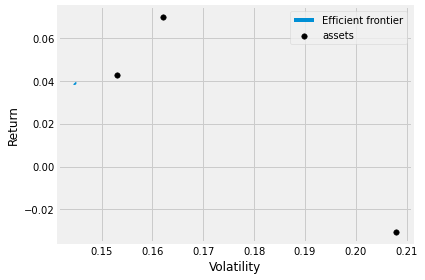

In [18]:
# Select portfolio of XLB, VOX, XLE for displaying EF

# DataFrame of selected ETF for portfolio
df3 = spdrs_price_df[list(trained_portfolios.iloc[:,0][0])] # Select XLB,VOX, XLE
# Calculate the expected returns and the annualized sample covariance matrix of asset returns
mu3 = expected_returns.mean_historical_return(df3)
S3 = risk_models.sample_cov(df3)

# Optimize for maximum sharpe ratio
ef3 = EfficientFrontier(mu3, S3, weight_bounds=(0,1))   # Determine the EF under long only
ef3.add_constraint(lambda w1: w1 >= 0.1)                # Add a constraint minimum weight of 10%
ef3.add_constraint(lambda w1: w1 <= 0.4)                # Add a constraint maximum weight of 40%
plotting.plot_efficient_frontier(ef3)
weights3 = ef3.max_sharpe()                             # optimizes for maximal Sharpe ratio
cleaned_weights3 = ef3.clean_weights()                  # rounds the weights and clips near-zeros
print(cleaned_weights3)

ef3.portfolio_performance(verbose=True)

### 2.5 Discuss the impacts on the EF under constraints in detail.  Comment on capital requirements and fiduciary responsibilities associated with these constraints.

In [19]:
# Collect data of all portfolio performance in each type of constraint
compare_perf = pd.DataFrame([average_perf_no_constraint, average_long, average_weight_constraint]).T
compare_perf.columns = ['no_constraint', 'long_only', 'weight_constraint']
compare_perf

,no_constraint,long_only,weight_constraint
Annual_Return,0.173182,0.133766,0.106981
Annual_Volatility,0.158158,0.134716,0.127704
Sharpe_Ratio,0.953812,0.841062,0.688679


From above dataframe (compare_perf), we will see 

1. In case of no constraints, 
we observed that non-constraint portfolios have the highest value in expected annual return, average annual volatilities and average sharpe ratio.

2. In case of long only constraints,
we observed that portfolios have the highest value in expected annual return, average annual volatilities and average sharpe ratio.

3. In case of weight constraints (minimum weight of 10% and maximum weight of 40% are imposed), 
we observed that portfolios have the lowest value in expected annual return, average annual volatilities and average sharpe ratio.

So, 
1. Each investor should choose the constraints that best suit their needs (high return or low risk). 
2. If we require low risk, we should select weight constraints. And we should consider several sets of weights constraints and show their impact on the optimized portfolio weights. We think that it may be useful to complete this analysis for getting the lowest risk.
3. we may verify that its weights constraints are compatible with its views on volatilities, risk factors, Sharpe ratios, etc.